# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
from scipy.stats import binned_statistic

# Defining parameters

In [2]:
# Defining sectors to use and LCs for each sector
sectors_dic = {27:[1,2]}
sectors = list(sectors_dic.keys())

#Defining relevant directories
output_dir = '/Users/samsonmercier/Desktop/Work/Master/2023-2024/SAGE/sage_output/AU_Mic/'
input_dir = '/Users/samsonmercier/Desktop/Work/Master/2023-2024/AUMic_data/Formatted_TESS'

#Defining dictionary with planet information -> to remove their transits
planet_propdic = {}
planet_propdic['AUMicb']={}
planet_propdic['AUMicb']['T0'] = 2458330.39051 #BJD
planet_propdic['AUMicb']['period'] = 8.463000  #days
planet_propdic['AUMicb']['T14'] = 3.4927/24    #days

planet_propdic['AUMicc']={}
planet_propdic['AUMicc']['T0'] = 2458342.2240 #BJD
planet_propdic['AUMicc']['period'] = 18.85969  #days
planet_propdic['AUMicc']['T14'] = 4.236/24    #days

planet_list = list(planet_propdic.keys())

#Defining the flare sigma-clipping thresholds
sigma_dic = {1:[1.5, 2.5], 27:[1.5, 1.5]}

# Defining rolling median function
def rolling_median(data, window):
    half_window = window // 2
    medians = np.full_like(data, np.nan)
    for i in range(half_window, len(data) - half_window):
        medians[i] = np.median(data[i - half_window:i + half_window + 1])
    return medians

#Defining number of points to bin each LC to
nbins = 500


# Retrieving data

SECTOR N.27, LC N.1
RETRIEVING DATA
REMOVING TRANSIT
REMOVING FLARES
BINNING DATA


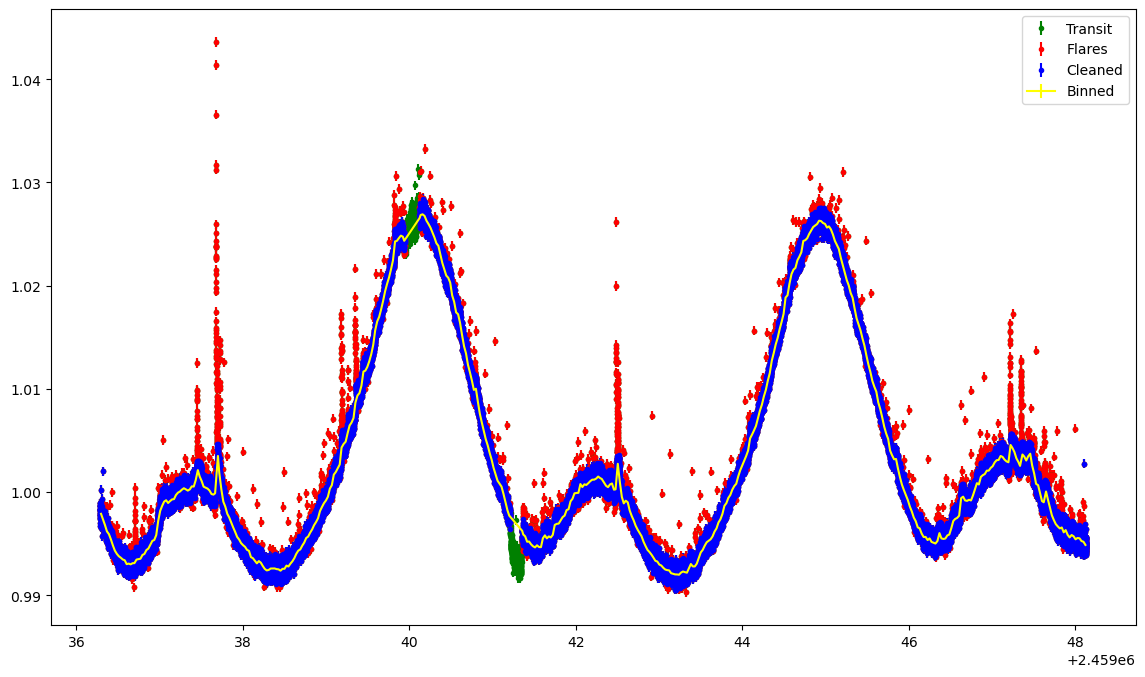

SECTOR N.27, LC N.2
RETRIEVING DATA
REMOVING TRANSIT
REMOVING FLARES
BINNING DATA


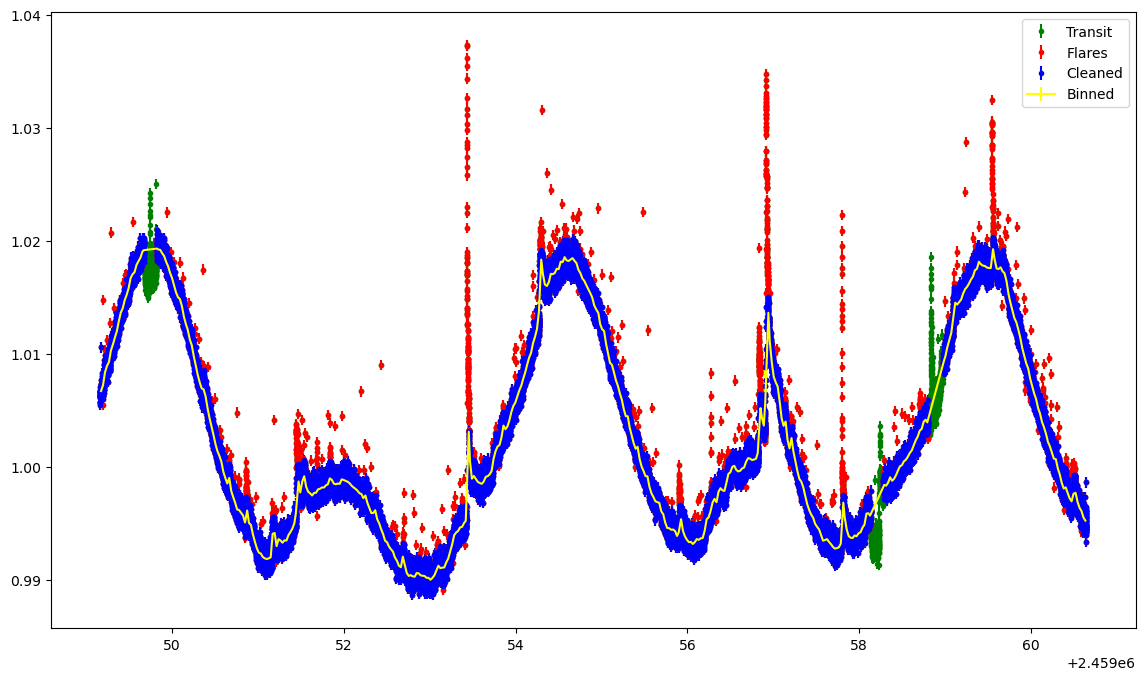

In [5]:
output_dic = {}
#Looping over sectors
for sector in sectors:
    #Getting sector name
    sector_name = f'sector_{sector}'
    sector_dir = output_dir+'/'+sector_name
    if not os.path.isdir(sector_dir):os.makedirs(sector_dir)
    output_dic[sector_name]={}

    #Looping over each transit
    for transitidx, transitnum in enumerate(sectors_dic[sector]):
        
        #Getting transit name
        LC_name = f'LC_{transitnum}'
        LC_dir = sector_dir+'/'+LC_name
        if not os.path.isdir(LC_dir):os.makedirs(LC_dir)
        output_dic[sector_name][LC_name]={}

        #Print
        print(f'SECTOR N.{sector}, LC N.{transitnum}')
        plt.figure(figsize=[14, 8])

        #Retrieving data
        print('RETRIEVING DATA')
        pd_data= pd.read_csv(input_dir + f'/Sector_{sector}/LC_{sector}_{transitnum}.csv')

        #Retrieving raw data
        mask_finite_flux = np.isfinite(pd_data['flux'])
        t = pd_data['time'][mask_finite_flux] + 2457000 #converting TESS BJD to BJD
        flux = pd_data['flux'][mask_finite_flux]
        flux_err = pd_data['flux_err'][mask_finite_flux]

        #Removing transit of planet considered   
        print('REMOVING TRANSIT')
        #% Defining mask to figure out the timestamps of in-transit exposures
        IT_mask = np.zeros(len(t), dtype=bool)

        #% Looping over all known planets in the system just in case
        for planet in planet_list:
            #% Getting planet properties 
            planet_dic = planet_propdic[planet]

            #% Number of transits that happened during epoch considered
            n_low  = np.round((min(t) - planet_dic['T0'])/planet_dic['period'], 0)
            n_high = np.round((max(t) - planet_dic['T0'])/planet_dic['period'], 0)
            #% Predicting transit midpoints during epoch considered
            predicted_T0s = planet_dic['T0'] + np.arange(n_low, n_high+1, 1)*planet_dic['period']

            #%Looping over all transits in epoch considered and updating mask to remove them
            for predicted_T0 in predicted_T0s:
                IT_mask |= (t>predicted_T0-(planet_dic['T14']/2)) & (t<predicted_T0+(planet_dic['T14']/2))

        #Plotting transits before and after
        plt.errorbar(t, flux, yerr=flux_err, fmt='.', color='green', label='Transit')
        t = t[~IT_mask]
        flux = flux[~IT_mask]
        flux_err = flux_err[~IT_mask]

        #Removing flares
        print('REMOVING FLARES')

        #% compute rolling median of the LC
        rolling_med = rolling_median(flux, window=300)

        #% "Normalize" LC
        raw_norm_flux = flux/rolling_med
        norm_flux = raw_norm_flux[~np.isnan(raw_norm_flux)]

        #% Sigma clip to remove flares
        sigma=sigma_dic[sector][transitidx]
        flare_mask = ((raw_norm_flux < np.median(norm_flux) - sigma*np.std(norm_flux)) | (raw_norm_flux > np.median(norm_flux) + sigma*np.std(norm_flux)))  

        #Masking points
        plt.errorbar(t, flux, yerr=flux_err, fmt='.', color='red', label='Flares')
        t=t[~flare_mask]
        flux=flux[~flare_mask]
        flux_err=flux_err[~flare_mask]


        #Binning data to make MCMC easier
        print('BINNING DATA')
        binned_t = binned_statistic(t, t, statistic='mean', bins=nbins)[0]
        binned_flux = binned_statistic(t, flux, statistic='mean', bins=nbins)[0]
        binned_flux_err = binned_statistic(t, flux, statistic='std', bins=nbins)[0]

        #Final cleaned result
        binned_flux = binned_flux[~np.isnan(binned_t)]
        binned_flux_err = binned_flux_err[~np.isnan(binned_t)]
        binned_t = binned_t[~np.isnan(binned_t)]
        output_dic[sector_name][LC_name]['t'] = binned_t
        output_dic[sector_name][LC_name]['flux'] = binned_flux
        output_dic[sector_name][LC_name]['flux_err'] = binned_flux_err
        plt.errorbar(t, flux, yerr=flux_err, fmt='.', color='blue', label='Cleaned')
        plt.errorbar(binned_t, binned_flux, yerr=binned_flux_err, color='yellow', linestyle='-', label='Binned')        
        plt.legend()
        plt.savefig(LC_dir+'/input_LC.pdf')
        plt.show()
        plt.close()

0.007606418708275164


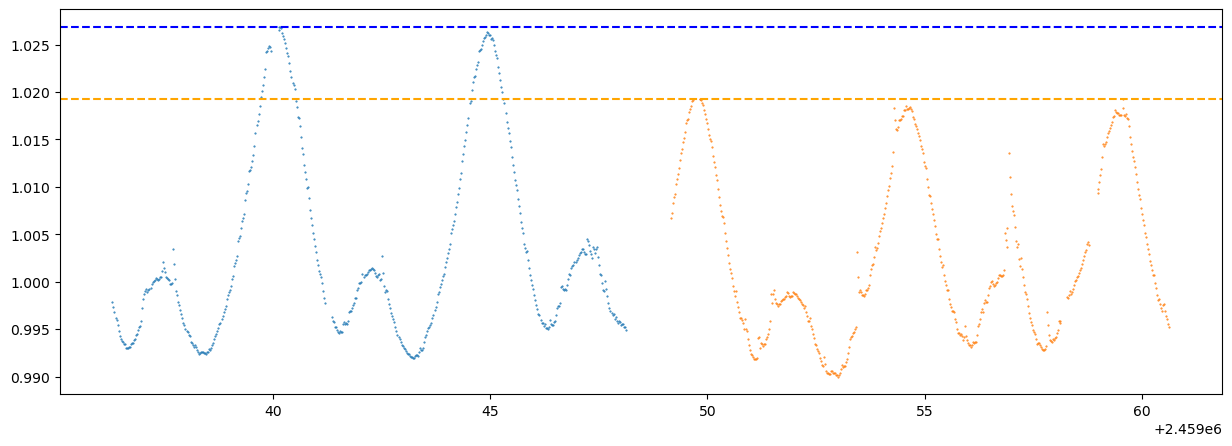

In [10]:

plt.figure(figsize=(15, 5))
plt.plot(output_dic['sector_27']['LC_1']['t'], output_dic['sector_27']['LC_1']['flux'], 'o', markersize=0.5, label='Sector 27 LC 1')
plt.axhline(np.max(output_dic['sector_27']['LC_1']['flux']), color='blue', linestyle='--', label='Median Flux LC 1')
plt.plot(output_dic['sector_27']['LC_2']['t'], output_dic['sector_27']['LC_2']['flux'], 'o', markersize=0.5, label='Sector 27 LC 2')
plt.axhline(np.max(output_dic['sector_27']['LC_2']['flux']), color='orange', linestyle='--', label='Median Flux LC 2')
print(np.abs(np.max(output_dic['sector_27']['LC_1']['flux']) - np.max(output_dic['sector_27']['LC_2']['flux'])))
plt.show()

0.006331801414489524


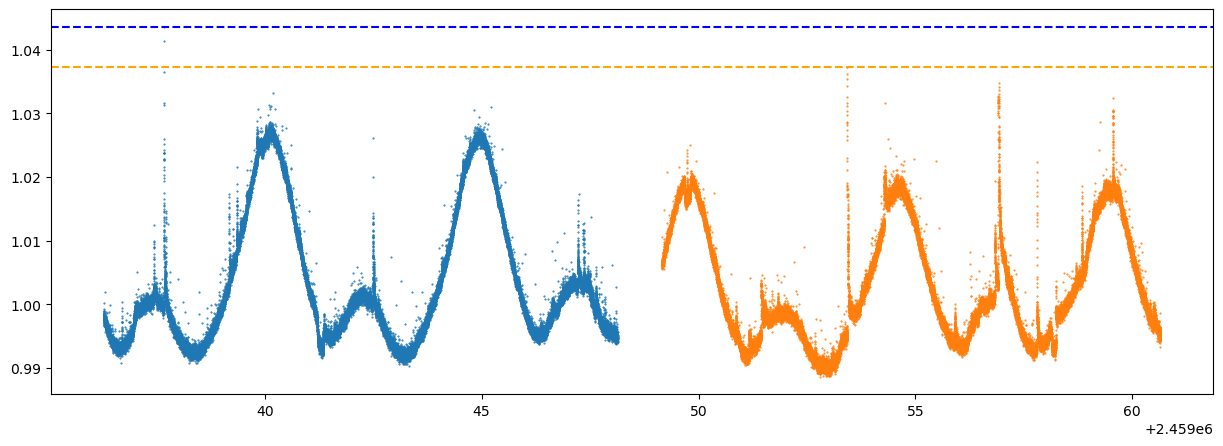

In [12]:
pd_data1= pd.read_csv(input_dir + f'/Sector_27/LC_27_1.csv')
pd_data2= pd.read_csv(input_dir + f'/Sector_27/LC_27_2.csv')

#Retrieving raw data
mask_finite_flux1 = np.isfinite(pd_data1['flux'])
t1 = pd_data1['time'][mask_finite_flux1] + 2457000 #converting TESS BJD to BJD
flux1 = pd_data1['flux'][mask_finite_flux1]
flux_err1 = pd_data1['flux_err'][mask_finite_flux1]

#Retrieving raw data
mask_finite_flux2 = np.isfinite(pd_data2['flux'])
t2 = pd_data2['time'][mask_finite_flux2] + 2457000 #converting TESS BJD to BJD
flux2 = pd_data2['flux'][mask_finite_flux2]
flux_err2 = pd_data2['flux_err'][mask_finite_flux2]

plt.figure(figsize=(15, 5))
plt.plot(t1, flux1, 'o', markersize=0.5, label='Sector 27 LC 1')
plt.axhline(np.max(flux1), color='blue', linestyle='--', label='Median Flux LC 1')
plt.plot(t2, flux2, 'o', markersize=0.5, label='Sector 27 LC 2')
plt.axhline(np.max(flux2), color='orange', linestyle='--', label='Median Flux LC 2')
print(np.abs(np.max(flux1) - np.max(flux2)))
plt.show()